<a href="https://colab.research.google.com/github/nunocesarsa/SENSECO_School_2021/blob/main/Senseco_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Package installion

In [1]:
!pip install prosail

!pip install sklearn-genetic

!pip install pysptools

!pip install pyswarm



     |████████████████████████████████| 149 kB 32.1 MB/s 
     |████████████████████████████████| 160 kB 37.8 MB/s 
     |████████████████████████████████| 8.1 MB 21.9 MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=8133749 sha256=6dbde578d80618747c664f5d58d84fb30a7c98bfac68e2f069bea27876ad3ab4
  Stored in directory: /root/.cache/pip/wheels/ee/61/31/fb8bf9e1d7508efcfce674a9dc4ac98e67cfe875a5567c4e7e
Successfully built pysptools
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4479 sha256=da0487a656f266ff264818691426c3238bd621c3750fbd42dd367c5c594e8440
  Stored in directory: /root/.cache/pip/wheels/ac/69/65/926e9c51b9fa99757cb43e8f6b74c5e6bb8b41a038b35c2db1
Successfully built pyswarm


#Importing packages

In [2]:
#importing packages

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
#import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance

#packages for optimization
from scipy.optimize import minimize, differential_evolution #scipy optimization and differential evolution from standard scipy
from pyswarm import pso #particle swarm



# Custom functions

In [65]:
###### A custom function to call prosail #####

## This function minimizes the way to call prosail so it is easier to understand what is happening
## if you want to keep stable parameters in prosail you should define them inside the function

def custom_prosail(cab,car,lai):
  import prosail
  #default parameters
  n= 1.
  #car=10.
  cw=0.005
  cm=0.005
  cbrown=0.01
  #lai=5
  typelidf=1 #this is the default option
  lidfa = -1 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters - got this from R package https://www.rdocumentation.org/packages/hsdar/versions/0.4.1/topics/PROSAIL
  #sun and viewing angle
  tts=33. #observation and solar position parameters
  tto=0. 
  psi=0.
  #for now i put them by hand but they should be an input of a custom function
  #tts=sol_zen #solar zenith angle
  #tto=inc_zen #sensor zenith angle
  #psi=raa
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,
                                 hspot,
                                 tts,tto,psi,
                                 typelidf, lidfb,
                                 prospect_version="D",
                                 factor='SDR', 
                                 rsoil=.5, psoil=.5)
  return(rho_out)



def Prosail2Nano(df_rho=None,path2file='/content/BioVIM2_2020-07-07_ENVI.csv'):

  df_WL = pd.read_csv(path2file,sep=',',decimal='.',header=1)
  df_WL.iloc[:,0] = df_WL.iloc[:,].round(0).astype(int)
  
  tot = pd.concat([df_rho,df_WL],axis=1,join="inner")

  return tot



def cost_spectra(x, rho):
  import pysptools as sptool
  
  #cost function can be easily editable here, all it is needed is to add
  #interactions between the various spectral differences methods on the return
  #cab,car,cw,cm,lai  = x
  cab,car,lai = x
  #cab = x

  #sim_canopy = custom_prosail(cab,car,cw,cm,lai)
  sim_canopy = custom_prosail(cab,car,lai)
  #sim_canopy = custom_prosail(cab)

  #converting numpy to dataframe
  df_sim = pd.DataFrame(data=np.arange(400,2501,1),columns=['Bands'])
  df_sim.insert(1,'Ref',sim_canopy)
  
  #converting to nano sensor
  df_nano = Prosail2Nano(df_sim)

  #extracting as numpy
  sim_spectra = df_nano.Ref.to_numpy()

  #print(sim_spectra.shape)
  #print(rho.shape)

  #cost calculation
  samerror            = sptool.distance.SAM(rho,sim_spectra ) 
#    samerror            = sptool.distance.SID(rho,sim_canopy)
#    samerror            = sptool.distance.chebyshev(rho,sim_canopy)
#    samerror            = sptool.distance.SAM(rho,sim_canopy) + (sptool.distance.SID(rho,sim_canopy)/2) + (sptool.distance.chebyshev(rho,sim_canopy)/2)
#    samerror            = sptool.distance.SAM(rho[0:1000],sim_canopy[0:1000])# + (sptool.distance.SAM(rho[1000:2101],sim_canopy[1000:2101])*10)
  return samerror

#cost_spectra_sentinel((30,10,4),rho)

#cost_spectra_sentinel((50,10,4),Prosail2Nano(df).Ref.to_numpy())


#Prosail2Nano(df)

## Testing custom functions

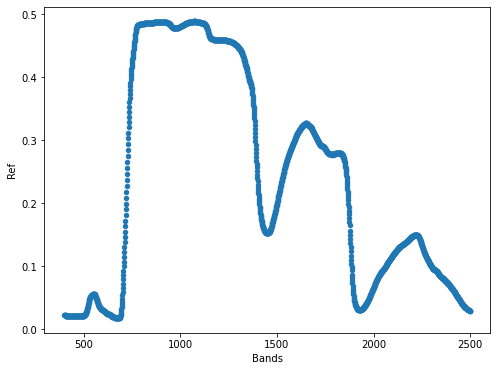

In [67]:
## Testing prosail call
rho=custom_prosail(40,10,3)

#converting rho (nump array) to a pandas dataframe with a column for wavelengths

df = pd.DataFrame(data=np.arange(400,2501,1),columns=['Bands'])
df.insert(1,'Ref',rho)
df.plot(x='Bands',y='Ref',kind="scatter",figsize=(8, 6))

#df is now our test dataframe



In [68]:
## Testing PROSAIL 2 nano
Prosail2Nano(df)

,Bands,Ref,0,1.145,8.37,0.05,4.05,0.075,0.545,0.445,2.375,13.35643564,15.41,0.21,2.295,0.465,0.1,2.44,8.225,4.52,8.72,0.13,5.69,0.55,0.855,1.065,5.53,4.588235294,9.915,0.345,12.185,0.025,1.565,1.795,4.2
0,400,0.021665,499,0.055729,0.056063,0.054922,0.057312,0.058690,0.057419,0.057135,0.057874,0.056183,0.056639,0.058456,0.056686,0.057646,0.056727,0.057012,0.055517,0.055251,0.055795,0.054551,0.054675,0.054894,0.054453,0.054416,0.052556,0.052873,0.054077,0.060175,0.053944,0.053537,0.057919,0.053089,0.053349
1,401,0.021664,502,0.057591,0.057809,0.056593,0.058986,0.060523,0.059218,0.058970,0.059662,0.057898,0.058526,0.060529,0.058444,0.059553,0.058651,0.058906,0.057255,0.057119,0.057717,0.056464,0.056835,0.056651,0.056348,0.056477,0.054507,0.054381,0.055657,0.061707,0.055399,0.055083,0.059576,0.054531,0.054924
2,402,0.021663,504,0.054194,0.054319,0.052954,0.055404,0.057284,0.055565,0.055196,0.055887,0.053737,0.054232,0.056215,0.054346,0.055214,0.054511,0.054640,0.052892,0.053301,0.053942,0.052518,0.052791,0.052592,0.052237,0.052458,0.050503,0.050252,0.051491,0.057935,0.051443,0.051105,0.055716,0.050244,0.050956
3,403,0.021662,506,0.055885,0.056206,0.054925,0.057436,0.059047,0.057071,0.056634,0.057396,0.056070,0.056636,0.058776,0.056411,0.057686,0.056626,0.056767,0.055158,0.055047,0.055730,0.054321,0.054688,0.054535,0.054107,0.054157,0.052133,0.051769,0.053059,0.059509,0.052946,0.052642,0.057460,0.051535,0.052630
4,404,0.021662,508,0.056813,0.057162,0.055783,0.058185,0.060159,0.058605,0.058309,0.059041,0.057179,0.057625,0.059849,0.057973,0.058627,0.058271,0.058134,0.056210,0.056208,0.056894,0.055459,0.055844,0.055565,0.055296,0.055214,0.053161,0.053033,0.054454,0.061060,0.054211,0.053928,0.058856,0.053014,0.053991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,611,0.027101,969,0.421388,0.426537,0.417511,0.411095,0.470227,0.416383,0.422577,0.416104,0.403027,0.431845,0.426431,0.426352,0.392792,0.435440,0.429120,0.375305,0.385587,0.415045,0.410214,0.392964,0.402823,0.385321,0.399157,0.368943,0.370670,0.344821,0.419164,0.379716,0.376236,0.401126,0.343441,0.341804
212,612,0.026771,971,0.431081,0.436344,0.427582,0.421303,0.481772,0.427896,0.433934,0.429468,0.417120,0.445211,0.436924,0.433529,0.408219,0.441700,0.436339,0.389295,0.387896,0.418077,0.414314,0.396582,0.404715,0.388174,0.401704,0.372404,0.382166,0.356710,0.424186,0.387003,0.382941,0.409014,0.357334,0.350826
213,613,0.026445,973,0.432353,0.439548,0.429604,0.423784,0.484824,0.426622,0.432154,0.427122,0.417904,0.444008,0.436118,0.427296,0.405163,0.435614,0.429957,0.386913,0.390826,0.421347,0.418810,0.400554,0.406880,0.389237,0.408808,0.375958,0.379726,0.352030,0.425910,0.386801,0.383584,0.409010,0.351278,0.347498
214,614,0.026120,976,0.437030,0.445187,0.435376,0.428805,0.487458,0.429057,0.434730,0.429212,0.418922,0.450795,0.444969,0.439644,0.409954,0.448201,0.441878,0.391123,0.393452,0.423947,0.422676,0.408481,0.415677,0.398120,0.409891,0.377049,0.377623,0.351370,0.424455,0.385443,0.381074,0.408718,0.350171,0.347876


In [70]:
##testing cost function

df = pd.DataFrame(data=np.arange(400,2501,1),columns=['Bands'])
df.insert(1,'Ref',rho)

cost_spectra((70,30,4),Prosail2Nano(df).Ref.to_numpy())


0.2546865712064846

#Optimization example

## Parameter range:

In [71]:
max_cab=100. #add 1
#max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_car=40 #0.008 #add 0.001 
max_lai = 6 #add 0.1

min_cab = 10.
min_car = 1
min_lai = 1

#init prosail parameters - halfway
init_cab = (max_cab+min_cab)*.5
init_car  = (max_car+min_car)*.5
init_lai = (max_lai+min_lai)*.5

## Set up

In [72]:
##making a tuple that holds the bounds for each trait
bnds = ((min_cab,max_cab),(min_car,max_car),(min_lai,max_lai))

#making a list for the initial points
test_trait = [init_cab,init_car,init_lai]

#options 
shared_opt = {'eps': 0.0001,'disp': True, 'maxiter':500}

#boundary conditions - particle swarm
lb = [min_cab,min_car,min_lai]
ub = [max_cab,max_car,max_lai]
bnds2 = [lb,ub]

##only cab
bnds_cab = ((min_cab,max_cab))
#making a list for the initial points
test_trait_cab = [init_cab]

#boundary conditions - particle swarm
lb_cab = [min_cab]
ub_cab = [max_cab]
bnds2_cab = [lb,ub]

len(bnds_cab)

2

## Running examples

In [73]:

example_BFGS = minimize(cost_spectra,test_trait,args=(Prosail2Nano(df).Ref.to_numpy()),
                       bounds=bnds,
                       method="L-BFGS-B",options=shared_opt)

print("BFGS:")
print(example_BFGS.x)
#example_BFGS

example_SLSQP = minimize(cost_spectra,test_trait,args=(Prosail2Nano(df).Ref.to_numpy()),
                       bounds=bnds,
                       method="SLSQP",options=shared_opt)

print("SLSQP")
print(example_SLSQP.x)

example_pso = pso(cost_spectra,
                lb,ub,
                args=[Prosail2Nano(df).Ref.to_numpy()],
                swarmsize=10) #it requires a np.array inside a np.array

print("Particle swarm:")
print(example_pso)

example_difevo = differential_evolution(cost_spectra,args=[Prosail2Nano(df).Ref.to_numpy()],
                                bounds=bnds,popsize=4,maxiter=500,recombination=.25,
                                seed=0,init='latinhypercube')

print("Differential evolution:")
print(example_difevo.x)

BFGS:
[39.99997411  9.99995264  2.99989352]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0012092995384122122
            Iterations: 25
            Function evaluations: 132
            Gradient evaluations: 25
SLSQP
[39.93634643 10.00482355  4.36421466]
Stopping search: Swarm best objective change less than 1e-08
Particle swarm:
(array([39.93655798, 10.0051555 ,  4.37588233]), 0.0012087394279400251)
Differential evolution:
[39.99999854 10.00000006  2.99999999]


# Loop

## Set up

In [74]:
df_spectra = pd.read_csv("/content/BioVIM2_2020-07-07_ENVI.csv",sep=',',decimal='.',header=1)
df_spectra

#loading another set to help select the validation
df_valid = pd.read_csv("/content/BioVIM2_2020-07-07_ENVI.csv",sep=',',decimal='.')


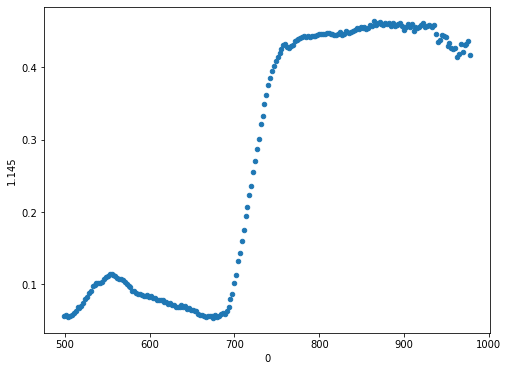

In [75]:
#quick plotting of the spectra
df_spectra.plot(x='0',y='1.145',kind="scatter",figsize=(8, 6))


## Main

In [76]:


#tables to store the final outputs
#out_df_BFGS    = pd.DataFrame(columns=["SampleID","Model","Disease","Cab","Car","LAI"])
#out_df_SLSQP   = pd.DataFrame(columns=["SampleID","Model","Disease","Cab","Car","LAI"])
#out_df_DIFFE   = pd.DataFrame(columns=["SampleID","Model","Disease","Cab","Car","LAI"])
#out_df_PSO     = pd.DataFrame(columns=["SampleID","Model","Disease","Cab","Car","LAI"])


#range(1,3)
for i in range(1,df_spectra.shape[1]):
  
  
  print("Processing sample:" ,i)

  #fetching the ith rho response
  rho = df_spectra.iloc[:,i]

  #fetching the ith disease info
  dis_val = df_valid.iloc[0,i]
   
  #running the optimizations - scipy optimize style
  #BFGS
  print("Running BFGS")
  tmp_BFGS = minimize(cost_spectra,test_trait,args=(rho),
                       bounds=bnds,
                       method="L-BFGS-B",options=shared_opt)
  
  tmp_BFGS_dict = {"SampleID":i,"Model":"BFGS","Disease":dis_val,"Cab":tmp_BFGS.x[0],"Car":tmp_BFGS.x[1],"LAI":tmp_BFGS.x[2]}

  #SLSQP
  print("Running SLSQP")
  tmp_SLSQP = minimize(cost_spectra,test_trait,args=(rho),
                       bounds=bnds,
                       method="SLSQP",options=shared_opt)
  
  tmp_SLSQP_dict = {"SampleID":i,"Model":"SLSQP","Disease":dis_val,"Cab":tmp_SLSQP.x[0],"Car":tmp_SLSQP.x[1],"LAI":tmp_SLSQP.x[2]}
                    
  #differential evolution
  print("Running Differential evolution")
  tmp_DIFFE = differential_evolution(cost_spectra,args=[rho],
                                     bounds=bnds,popsize=10,maxiter=500,recombination=.25,
                                     seed=0,init='latinhypercube')
  
  tmp_DIFFE_dict = {"SampleID":i,"Model":"DIFFE","Disease":dis_val,"Cab":tmp_DIFFE.x[0],"Car":tmp_DIFFE.x[1],"LAI":tmp_DIFFE.x[2]}

  #particle swarm
  print("Running Particle swarm optimization")
  tmp_PSO = pso(cost_spectra,
                lb,ub,
                args=[rho],
                swarmsize=5) #it requires a np.array inside a np.array

  tmp_PSO_dict = {"SampleID":i,"Model":"PSO","Disease":dis_val,"Cab":tmp_PSO[0][0],"Car":tmp_PSO[0][1],"LAI":tmp_PSO[0][2]}

  #appending to the dictionaries
  out_df_BFGS  = out_df_BFGS.append(tmp_BFGS_dict,ignore_index=True)
  out_df_SLSQP = out_df_SLSQP.append(tmp_SLSQP_dict,ignore_index=True)
  out_df_DIFFE = out_df_DIFFE.append(tmp_DIFFE_dict,ignore_index=True)
  out_df_PSO   = out_df_PSO.append(tmp_PSO_dict,ignore_index=True)



Processing sample: 1
Running BFGS
Running SLSQP
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.14631384164306538
            Iterations: 30
            Function evaluations: 154
            Gradient evaluations: 30
Running Differential evolution
Running Particle swarm optimization
Stopping search: Swarm best objective change less than 1e-08
Processing sample: 2
Running BFGS
Running SLSQP
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1461478065631097
            Iterations: 27
            Function evaluations: 138
            Gradient evaluations: 27
Running Differential evolution
Running Particle swarm optimization
Stopping search: Swarm best objective change less than 1e-08
Processing sample: 3
Running BFGS
Running SLSQP
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.14620873405083798
            Iterations: 32
            Function evaluations: 164

In [77]:
#out_df_BFGS
#out_df_SLSQP
#out_df_DIFFE
#out_df_PSO 

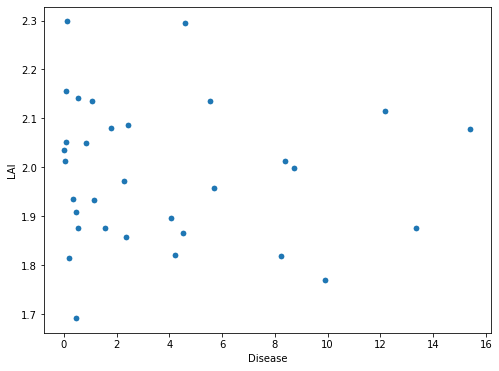

In [79]:
out_df_DIFFE.plot(x='Disease',y='LAI',kind='scatter',figsize=(8, 6))